In [1]:
import pandas as pd
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('wavelet_kantamal.csv')
df.head()

,spi,Approximation,D 1,D 2,D 3,D 4,D 5,D 6
0,-0.16,-0.05,-0.19,0.42,-0.11,-0.27,-0.69,0.14
1,-0.14,-0.04,-0.06,0.35,-0.50,-0.31,-0.67,0.15
2,0.21,-0.03,-0.11,0.14,-0.63,-0.31,-0.62,0.17
3,0.51,-0.02,-0.01,-0.15,-0.50,-0.21,-0.53,0.20
4,0.92,-0.03,-0.03,-0.32,-0.16,-0.03,-0.42,0.24


In [3]:
# X = dataset[['Approximation', 'D 1', 'D 3', 'D 6']].values  # Select the desired features
# y = dataset.iloc[:, 0].values  # Target variable (SPI)

<Figure size 640x480 with 0 Axes>

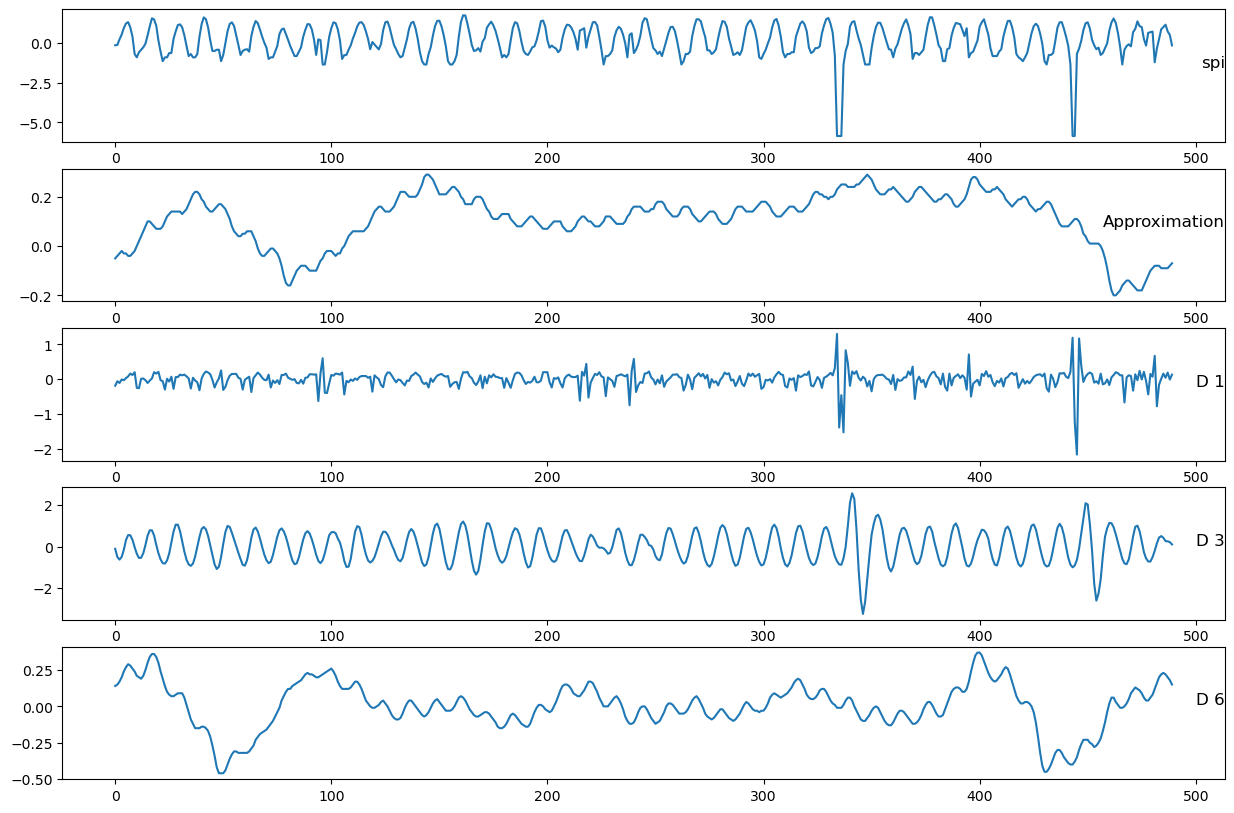

In [4]:
import matplotlib.pyplot as plt
values = df.values
# specify columns to plot
groups = [0, 1, 2, 4, 7]
i = 1
# plot each column
pyplot.figure()
plt.figure(figsize=(15,10))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [5]:
df=df.drop(['D 2','D 4','D 5'], axis=1)
df

,spi,Approximation,D 1,D 3,D 6
0,-0.16,-0.05,-0.19,-0.11,0.14
1,-0.14,-0.04,-0.06,-0.50,0.15
2,0.21,-0.03,-0.11,-0.63,0.17
3,0.51,-0.02,-0.01,-0.50,0.20
4,0.92,-0.03,-0.03,-0.16,0.24
...,...,...,...,...,...
485,0.98,-0.09,0.16,0.42,0.23
486,1.13,-0.09,0.04,0.26,0.22
487,0.71,-0.09,0.19,0.25,0.20
488,0.48,-0.08,-0.01,0.21,0.18


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6, 7, 8, 9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var3(t)  \
1   0.751979   0.306122   0.570605   0.713080   0.539655   0.496774  0.608069   
2   0.754617   0.326531   0.608069   0.698312   0.472414   0.483871  0.593660   
3   0.800792   0.346939   0.593660   0.654009   0.450000   0.483871  0.622478   
4   0.840369   0.367347   0.622478   0.592827   0.472414   0.516129  0.616715   
5   0.894459   0.346939   0.616715   0.556962   0.531034   0.574194  0.634006   

    var4(t)   var5(t)   var6(t)   var7(t)   var8(t)  
1  0.698312  0.472414  0.483871  0.121019  0.734940  
2  0.654009  0.450000  0.483871  0.152866  0.759036  
3  0.592827  0.472414  0.516129  0.210191  0.795181  
4  0.556962  0.531034  0.574194  0.280255  0.843373  
5  0.556962  0.612069  0.648387  0.343949  0.879518  


In [7]:
values = reframed.values
n_train_months = 30 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(360, 1, 11) (360,) (129, 1, 11) (129,)


Epoch 1/100
5/5 - 2s - loss: 0.4978 - val_loss: 0.4161 - 2s/epoch - 432ms/step
Epoch 2/100
5/5 - 0s - loss: 0.3849 - val_loss: 0.3295 - 59ms/epoch - 12ms/step
Epoch 3/100
5/5 - 0s - loss: 0.2769 - val_loss: 0.2628 - 49ms/epoch - 10ms/step
Epoch 4/100
5/5 - 0s - loss: 0.1780 - val_loss: 0.2145 - 48ms/epoch - 10ms/step
Epoch 5/100
5/5 - 0s - loss: 0.1312 - val_loss: 0.2024 - 49ms/epoch - 10ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1420 - val_loss: 0.2039 - 48ms/epoch - 10ms/step
Epoch 7/100
5/5 - 0s - loss: 0.1469 - val_loss: 0.2029 - 44ms/epoch - 9ms/step
Epoch 8/100
5/5 - 0s - loss: 0.1387 - val_loss: 0.2017 - 50ms/epoch - 10ms/step
Epoch 9/100
5/5 - 0s - loss: 0.1295 - val_loss: 0.2034 - 52ms/epoch - 10ms/step
Epoch 10/100
5/5 - 0s - loss: 0.1286 - val_loss: 0.2059 - 46ms/epoch - 9ms/step
Epoch 11/100
5/5 - 0s - loss: 0.1301 - val_loss: 0.2059 - 45ms/epoch - 9ms/step
Epoch 12/100
5/5 - 0s - loss: 0.1290 - val_loss: 0.2039 - 47ms/epoch - 9ms/step
Epoch 13/100
5/5 - 0s - loss: 0.1278 - val

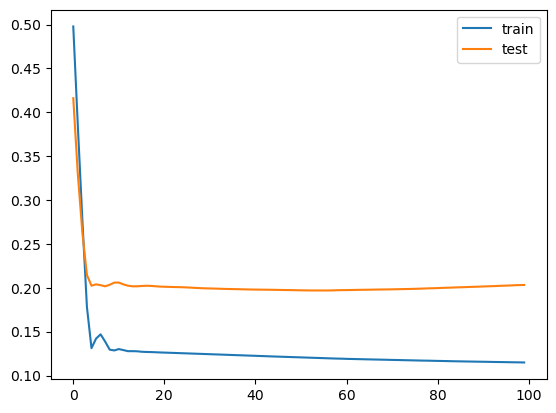

In [8]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [10]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

5/5 [==============================] - 0s 3ms/step


In [11]:
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = inv_yhat[:, 0]
inv_yhat = inv_yhat.reshape(-1, 1)  # Reshape inv_yhat to match scaler.inverse_transform() requirements
inv_yhat = scaler.inverse_transform(inv_yhat)


ValueError: non-broadcastable output operand with shape (129,1) doesn't match the broadcast shape (129,8)

In [ ]:
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [ ]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
inv_yhat

In [21]:
values = reframed.values
n_train_months = 10 * 12
train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(120, 1, 11) (120,) (369, 1, 11) (369,)


Epoch 1/50
2/2 - 2s - loss: 0.5157 - val_loss: 0.4319 - 2s/epoch - 1s/step
Epoch 2/50
2/2 - 0s - loss: 0.4751 - val_loss: 0.3886 - 59ms/epoch - 30ms/step
Epoch 3/50
2/2 - 0s - loss: 0.4357 - val_loss: 0.3464 - 43ms/epoch - 22ms/step
Epoch 4/50
2/2 - 0s - loss: 0.4014 - val_loss: 0.3058 - 42ms/epoch - 21ms/step
Epoch 5/50
2/2 - 0s - loss: 0.3709 - val_loss: 0.2665 - 46ms/epoch - 23ms/step
Epoch 6/50
2/2 - 0s - loss: 0.3422 - val_loss: 0.2282 - 43ms/epoch - 21ms/step
Epoch 7/50
2/2 - 0s - loss: 0.3156 - val_loss: 0.1907 - 46ms/epoch - 23ms/step
Epoch 8/50
2/2 - 0s - loss: 0.2945 - val_loss: 0.1578 - 39ms/epoch - 20ms/step
Epoch 9/50
2/2 - 0s - loss: 0.2778 - val_loss: 0.1327 - 52ms/epoch - 26ms/step
Epoch 10/50
2/2 - 0s - loss: 0.2630 - val_loss: 0.1189 - 42ms/epoch - 21ms/step
Epoch 11/50
2/2 - 0s - loss: 0.2503 - val_loss: 0.1170 - 43ms/epoch - 21ms/step
Epoch 12/50
2/2 - 0s - loss: 0.2397 - val_loss: 0.1248 - 41ms/epoch - 20ms/step
Epoch 13/50
2/2 - 0s - loss: 0.2318 - val_loss: 0.138

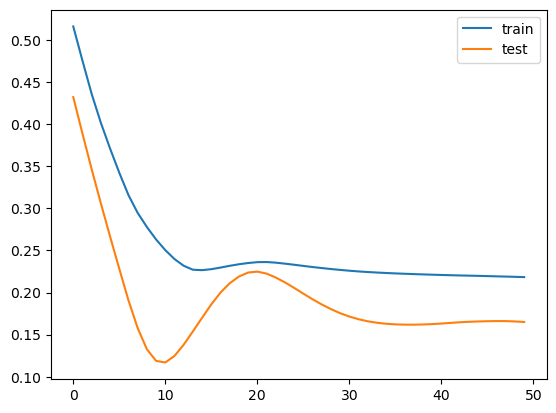

In [22]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

12/12 [==============================] - 0s 3ms/step


ValueError: operands could not be broadcast together with shapes (369,11) (8,) (369,11) 